# HUをグレースケールに変換する

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import time
import nibabel as nib
import ctvis
from glob import glob
from pathlib import Path
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

#### **private function**
- *get_df のように script内でしか呼ばれない関数*
    - 接頭辞に _ (アンダースコア)をつける
    - **この　script　内でしか呼ばれませんと明示的に伝える**


- <u>呼ぼうとすれば呼べるが...</u>
    - *外から呼ばれるよな事は想定していない関数ですよ！という意思表示*
    - *pythonの処理的には関係が無いので注意する*


#### **from　ctvis　import　*　( アスタリスク )** での　import
- *( * : アスタリスク )で import した時には _ (アンダースコア)の関数は呼び出せない*

In [2]:
df = ctvis.get_df_all('../public-covid-data')

In [3]:
index = 0
volume = ctvis.load_nifti(df.iloc[index]['FilePathImage'])
mask = ctvis.load_nifti(df.iloc[index]['FilePathMask'])
mask_color = ctvis.label_color(mask)
print(volume.shape)
print(mask.shape)
print(mask_color.shape)
print(volume.min())
print(volume.max())
print(mask_color.min())
print(mask_color.max())

(630, 630, 45)
(630, 630, 45)
(630, 630, 45, 3)
-1414.765380859375
212.7372589111328
0.0
255.0


- *CT data と Mask color data が合っていないので上手く　　Overlay　できない*
    - **Overlay　できるようにする為 CT data を　0 ~ 255 の値に変換する**


## 値の rerange をするアルゴリズム
- *CT data と Mask color data が合っていないので上手く　　Overlay　できない*
    - **Overlay　できるようにする為 CT data を　0 ~ 255 の値に変換する**


- *例 ）　-1300 ~ 300 の値を持つ　CT data を　0 ~ 255 に変換する*
    1. -1300 ~ 300　->　0 ~ 1
        - X -最小値 / （最大値 - 最小値）
        $$\frac{(x-min)}{max-min}$$
        - [ 2, 3, 4, 5, 6, 7 ] の場合
        $$\frac{7-2}{7-2}=1$$
        $$\frac{6-2}{7-2}=\frac{4}{5}$$
        $$\frac{5-2}{7-2}=\frac{3}{5}$$
        $$\frac{4-2}{7-2}=\frac{2}{5}$$
        $$\frac{3-2}{7-2}=\frac{1}{5}$$
        $$\frac{2-2}{7-2}=\frac{0}{5}=0$$
    2. 0 ~ 1　->　0 ~ 255
        - ＊（掛ける） 255

In [4]:
maxhu = np.max(volume)
minhu = np.min(volume)
volume_rerange = (volume - minhu) / (maxhu-minhu)
volume_rerange.max()

1.0

- もし二次元の画像が入ってきた場合に、全ての　pix　が真っ黒で　0　で error　になてしまう可能性もある！
    - if文　を使用して max と min が同じだったら...　してはじいてあげる。 という風にしてもいい

In [5]:
# 0 が入ってしまうと error になってしまうので　error ハンドリングをしておく
maxhu = np.max(volume)
minhu = np.min(volume)
volume_rerange = (volume - minhu) / 0
volume_rerange.max()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


nan

In [6]:
volume_rerange

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [7]:
# error　ハンドリング
maxhu = np.max(volume)
minhu = np.min(volume)
volume_rerange = (volume - minhu) / max((maxhu-minhu), 1e-3)
volume_rerange.max()

1.0

In [8]:
maxhu = np.max(volume)
minhu = np.min(volume)
volume_rerange = (volume - minhu) / max((maxhu-minhu), 1e-3)
volume_rerange = volume_rerange * 255
print(volume_rerange.min())
print(volume_rerange.max())
print(volume_rerange.shape)

0.0
255.0
(630, 630, 45)


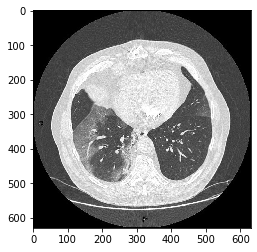

In [9]:
plt.imshow(volume_rerange[:, :, 30], cmap='gray')

### 値は0 ~ 255 にはなったが… 
- *CT data は　RGBのチャネルになっていないので、shpaeが違う*
    - **color 画像ではないが、重ね合わせる時に　shape が合っていた方が重ね合わせ易い**

In [10]:
volume_rerange.shape

(630, 630, 45)

In [11]:
volume_rerange = np.stack([volume_rerange, volume_rerange, volume_rerange], axis=-1)
volume_rerange.shape

(630, 630, 45, 3)

In [12]:
maxhu = np.max(volume)
minhu = np.min(volume)
volume_rerange = (volume - minhu) / max((maxhu-minhu), 1e-3)
volume_rerange = volume_rerange * 255
volume_rerange = np.stack([volume_rerange, volume_rerange, volume_rerange], axis=-1)
print(volume_rerange.min())
print(volume_rerange.max())
print(volume_rerange.shape)

0.0
255.0
(630, 630, 45, 3)


## 上記を関数にする

In [13]:
df = ctvis.get_df_all('../public-covid-data')
index = 0
volume = ctvis.load_nifti(df.iloc[index]['FilePathImage'])
mask = ctvis.load_nifti(df.iloc[index]['FilePathMask'])
mask_color = ctvis.label_color(mask)

In [14]:
def hu_to_gray(volume):
    maxhu = np.max(volume)
    minhu = np.min(volume)
    volume_rerange = (volume - minhu) / max((maxhu-minhu), 1e-3)
    volume_rerange = volume_rerange * 255
    volume_rerange = np.stack([volume_rerange, volume_rerange, volume_rerange], axis=-1)
    
    # astype(np.uint8) にすることで　0 ~ 255 の　int　で返してくれる
    return volume_rerange.astype(np.uint8)

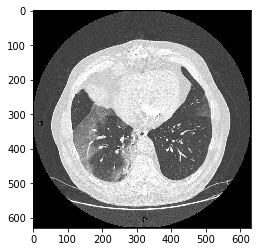

In [15]:
volume_gray = hu_to_gray(volume)
plt.imshow(volume_gray[:, :, 30])

In [16]:
print(volume_gray.max())
print(volume_gray.min())
print(volume_gray.shape)

255
0
(630, 630, 45, 3)


## script からの読み込み Test

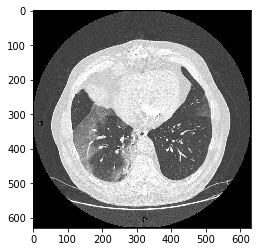

In [18]:
df = ctvis.get_df_all('../public-covid-data')
index = 0
volume = ctvis.load_nifti(df.iloc[index]['FilePathImage'])
mask = ctvis.load_nifti(df.iloc[index]['FilePathMask'])
mask_color = ctvis.label_color(mask)
volume_gray = ctvis.hu_to_gray(volume)
plt.imshow(volume_gray[:, :, 30])

In [19]:
print(volume_gray.max())
print(volume_gray.min())
print(volume_gray.shape)

255
0
(630, 630, 45, 3)
